<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Подготовка-тренировочных-и-тестовых-данных" data-toc-modified-id="Подготовка-тренировочных-и-тестовых-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка тренировочных и тестовых данных</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

from skopt import BayesSearchCV

In [3]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 
df.index.name=None #удаляем название индексов

In [4]:
df.index.is_monotonic #проверяем индексы на соответствие хронологическому порядку

/var/folders/1x/1w_zvycx51vgmxmwtzcxw7zr0000gn/T/ipykernel_17315/2850924553.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic #проверяем индексы на соответствие хронологическому порядку


True

In [5]:
df = df.resample('1H').sum() #проводим рассемплирование по одному часу

## Анализ

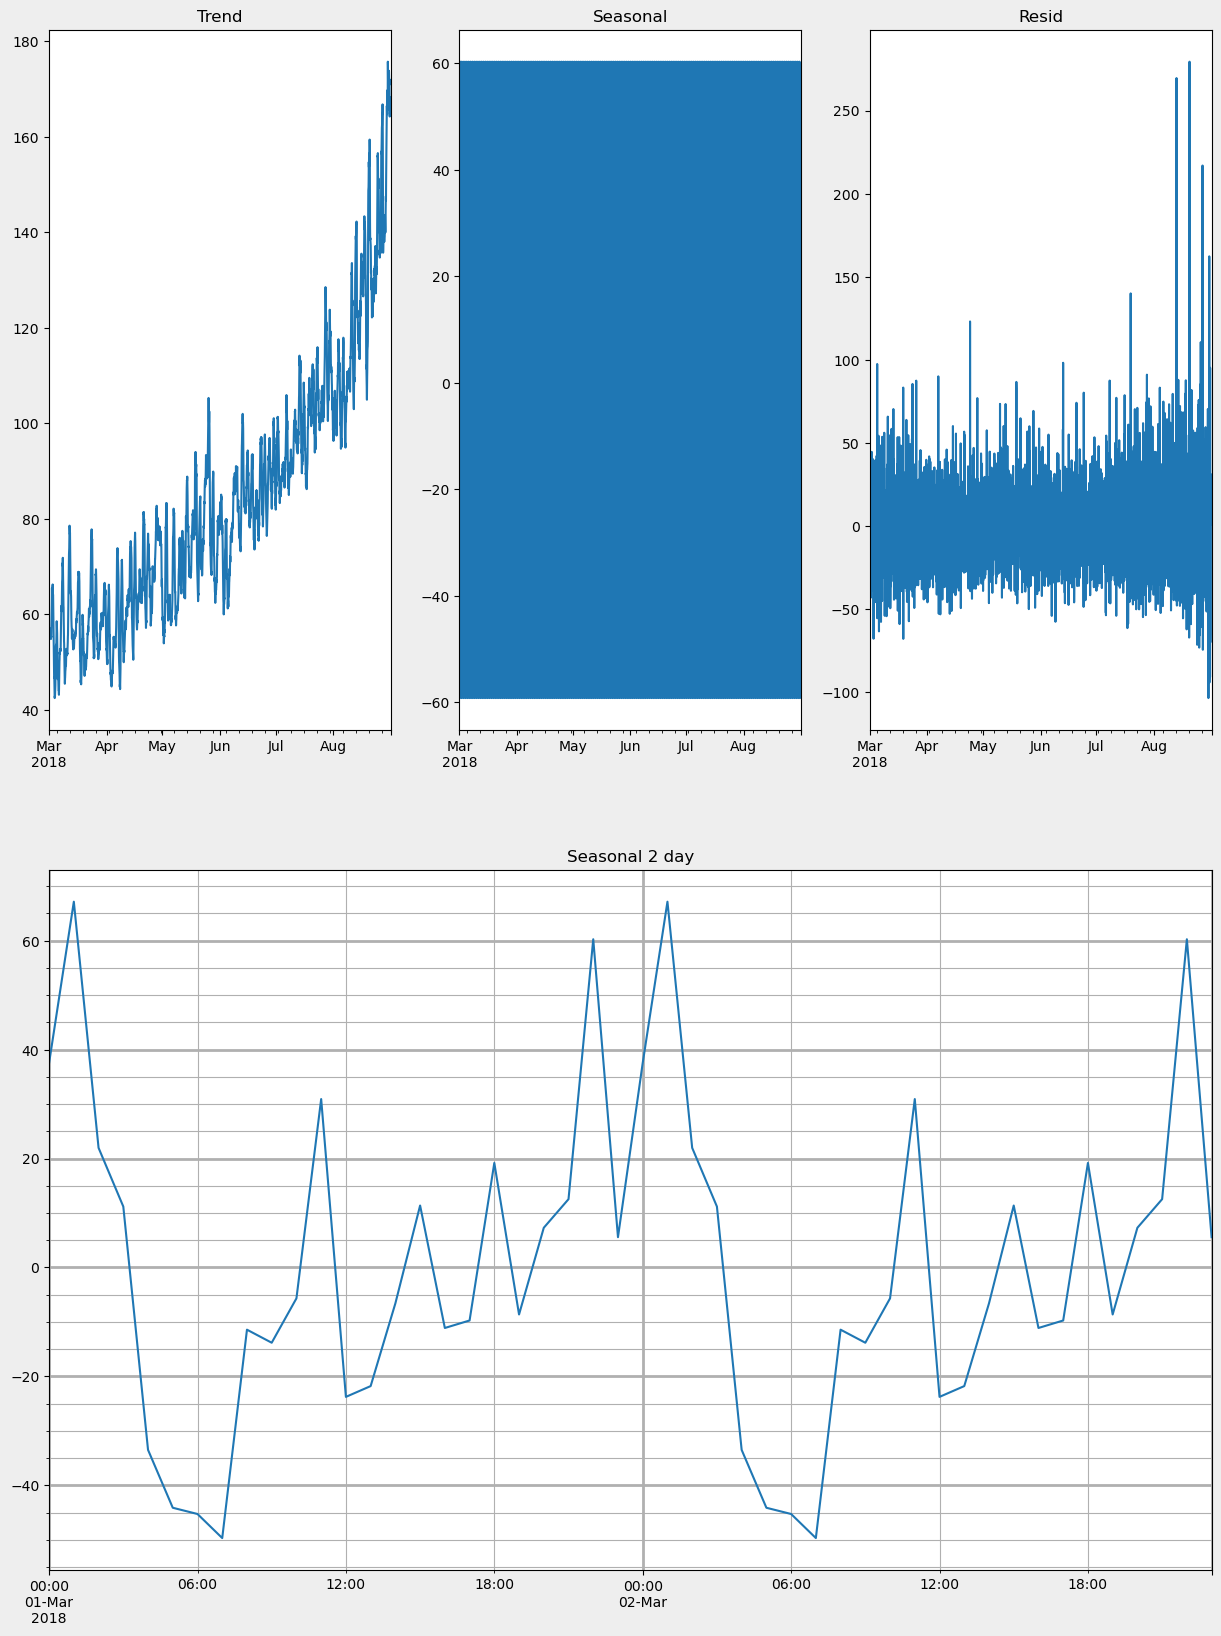

In [6]:
# проанализируем временной ряд на тренд и сезонность

decomposed = seasonal_decompose(df)#расскладываем временной ряд на составляющие

# для анализа сезонности уменьшим интервал
decomposed_2 = seasonal_decompose(df['2018-03-01':'2018-03-02'])

plt.figure(figsize=(15,20), facecolor='#eee') #задаем размер фигуры

plt.subplot(231) #задаем область для графика
decomposed.trend.plot(ax=plt.gca()) 
plt.title('Trend')

plt.subplot(232)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(233)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')

plt.subplot(212)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Seasonal 2 day')
plt.minorticks_on()
plt.grid(which='major', lw=2)
plt.grid(which='minor')

plt.show()

**Вывод:**
- С начала марта по конец Августа наблюдается восходящий тренд, что говорит об увелиичении числа заказоа такси.
- Сезонность равна одному дню. Примерно с 01:00 до 07:00 наблюдается спад заказов. Наибольшая активнасть при ходится на 01:00, 22:00 и 11:00.
- Оставшиеся данные resid неимеют объяснения.

## Обучение

### Создание признаков

In [7]:
def make_features(df, max_lag, rolling_mean_size):
    
    data = df.copy()
    
    #календарные признаки
    data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    #отстающие значения
    for n in range(1, max_lag+1):
        data['lag_{}'.format(n)] = data['num_orders'].shift(n)
        
    #скользящая средняя
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [8]:
data = make_features(df, 24, 7)

In [9]:
#удалим наблюдения с пропущенными значениями

data.dropna(inplace=True)
data.shape

(4392, 28)

### Подготовка тренировочных и тестовых данных

In [11]:
features = data.drop('num_orders', axis=1)
target = data.num_orders

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            shuffle=False,
                                                                            test_size=.1)


features_train.shape, target_train.shape, features_test.shape, target_test.shape

((3952, 27), (3952,), (440, 27), (440,))

In [12]:
def RMSE(data, predicts):
    rmse = ((sum((data - predicts)**2))/len(predicts))**0.5
    return rmse

def scorrer():
    return make_scorer(RMSE, greater_is_better=False)

In [13]:
pipelin = Pipeline([('scaler', StandardScaler()),
                    ('model', LinearRegression())])
pipelin

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [14]:
linear = {'model': [LinearRegression()]}

lasso = {
    'model': [Lasso(random_state=42)],
    'model__alpha': (0.1, 0.9),
    'model__tol': (1e-8, 1e+8),
    'model__selection':['cyclic', 'random']
}

gbr = {
    'model': [GradientBoostingRegressor(random_state=42)],
    'model__loss': ['huber', 'quantile'],
    'model__learning_rate': (0.1, 1),
    'model__n_estimators': (50,250),
    'model__max_depth': (2,10)
    
}

In [15]:
%%time

model_bayes = BayesSearchCV(pipelin,
                            [(linear, 1), (lasso, 40), (gbr, 40)],
                            cv=TimeSeriesSplit(),
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)

model_bayes.fit(features_train, target_train)
model_bayes.best_score_

/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 1min 22s, sys: 3min 16s, total: 4min 39s
Wall time: 4min 1s


-25.730894275156896

In [16]:
pd.DataFrame(model_bayes.cv_results_).sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__selection,param_model__tol,param_model__learning_rate,param_model__loss,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
79,5.668523,1.814052,0.004943,0.000338,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,247,{'model': GradientBoostingRegressor(loss='hube...,-22.894149,-22.465816,-24.034381,-26.113870,-33.146255,-25.730894,3.917148,1
77,3.209651,1.082373,0.003360,0.000248,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,181,{'model': GradientBoostingRegressor(loss='hube...,-22.939344,-22.442109,-24.141717,-25.829127,-33.505392,-25.771538,4.039271,2
72,3.151391,1.070517,0.003139,0.000191,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,179,{'model': GradientBoostingRegressor(loss='hube...,-22.939352,-22.475874,-24.150820,-25.815794,-33.498232,-25.776015,4.030212,3
71,3.156761,1.067239,0.003254,0.000417,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,179,{'model': GradientBoostingRegressor(loss='hube...,-22.939352,-22.475874,-24.150820,-25.815794,-33.498232,-25.776015,4.030212,3
70,3.381302,1.099459,0.003377,0.000286,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,184,{'model': GradientBoostingRegressor(loss='hube...,-22.940731,-22.478312,-24.134699,-25.836554,-33.492372,-25.776534,4.028733,5
74,3.269172,1.104693,0.003259,0.000179,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,185,{'model': GradientBoostingRegressor(loss='hube...,-22.941976,-22.482267,-24.133918,-25.838164,-33.491491,-25.777563,4.027641,6
75,3.330606,1.139607,0.003802,0.000586,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,185,{'model': GradientBoostingRegressor(loss='hube...,-22.941976,-22.482267,-24.133918,-25.838164,-33.491491,-25.777563,4.027641,6
73,3.293856,1.106769,0.003268,0.000206,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,186,{'model': GradientBoostingRegressor(loss='hube...,-22.941806,-22.480996,-24.148544,-25.841201,-33.482179,-25.778945,4.023126,8
69,3.310681,1.131870,0.003237,0.000175,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,189,{'model': GradientBoostingRegressor(loss='hube...,-22.941112,-22.483529,-24.152916,-25.855844,-33.520098,-25.790700,4.037021,9
64,3.425378,1.184280,0.003390,0.000207,"GradientBoostingRegressor(loss='huber', max_de...",NaN,NaN,NaN,0.1,huber,...,198,{'model': GradientBoostingRegressor(loss='hube...,-22.948210,-22.515837,-24.169365,-25.881245,-33.507588,-25.804449,4.024694,10


In [17]:
%%time

lgbm = {
    'model': [LGBMRegressor(random_state=42, feature_fraction=0.8, xgboost_dart_mode=True)],
    'model__learning_rate': (0.1, 1),
    'model__n_estimators': (200, 600),
    'model__objective': ['tweedie', 'poisson', 'regression_l1', 'quantile', 'huber', 'mape', 'fair'],
    'model__num_leaves': (30, 55)
}

model_lgbm = BayesSearchCV(pipelin,
                           lgbm,
                           cv=TimeSeriesSplit(),
                           scoring='neg_root_mean_squared_error',
                           n_iter=70,
                           n_jobs=-1)

model_lgbm.fit(features_train, target_train)
model_lgbm.best_score_

/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Oleg/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The object

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
CPU times: user 1min 44s, sys: 4min 19s, total: 6min 4s
Wall time: 2min 15s


-25.171794073378173

**Вывод:**
Лучшая модель LGBMRegressor показала результат метрики RMSE равный 25.17 с гиперпараметрами: learning_rate=1, num_leaves=36, n_estimators=600, random_state=42, objective='huber'.

## Тестирование

In [18]:
pred = model_lgbm.predict(features_test)
RMSE(target_test, pred)

43.234020750005

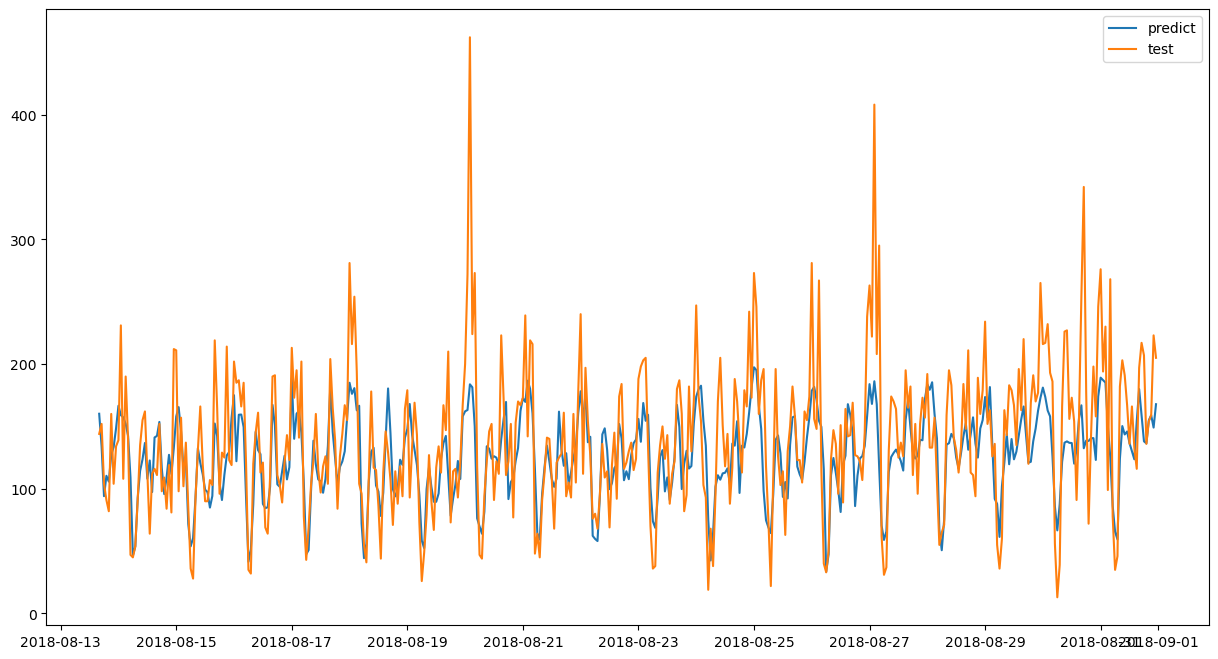

In [57]:
pred = pd.Series(pred, index=target_test.index)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()

ax.plot(pred, label='predict')
ax.plot(target_test, label='test')
ax.legend()
plt.show()

**Вывод:**
- На тестовой выборке получилось достичь значения метрики RMSE равное 43.23, что соответствует условию задания.
- Количество признаков "отстающее значение" пришлось довести до 24 для достижения необходимого результата.
- Из календарных признаков достаточно два: 1) номер месяца; 2) номер недели.
- Во временном ряде наблюдается восходя тренд, число заказов с начала марта по конец августа стремительно растет.